In [1]:
import numpy as np
import pandas as pd

from bokeh.plotting import show
from bokeh.models.annotations import Title
from bokeh.models import Plot, ColumnDataSource, Ellipse, Grid, LinearAxis, Text
from bokeh.io import output_notebook, export_png

from harrison_functions.utils.std.text import camel_to_snake_case
from harrison_functions.utils.plotting.plotly import plot_multiple_scatter, save_fig_as_png

pd.options.display.max_columns = None
output_notebook()

# troubleshooting
# from selenium import webdriver
# driver = webdriver.Firefox(executable_path='/home/harrisonized/geckodriver')

Loading BokehJS ...

In [2]:
save=False

In [3]:
def find_nearest_point(point, points:list):
    """O(n^2) algorithm to find the nearest point
    Can make this faster with binary search on one of the variables
    However, since this is a small dataset (20 nuclei per image), whatever
    
    >>> find_nearest_point(
        point=(281.415801, 135.945238),
        points=[(693.094713, 59.080090), (295.184921, 118.996760), (282.528024, 182.998269)],
    )
    (295.184921, 118.99676)
    """
    
    d = np.inf
    for x, y in points:
        d_current = np.sqrt((point[0]-x)**2+(point[1]-y)**2)
        if d_current < d:
            closest_point = (x, y)
            d = d_current
        
    return closest_point

# Data

In [4]:
# read in data
nuclei = pd.read_csv("data/nuclei_subset.csv")
puncta = pd.read_csv("data/puncta_subset.csv")

# filters
# nuclei = nuclei[(nuclei['eccentricity'] < 0.7)].copy()

In [5]:
# subset by image
# nuclei_subset = nuclei[nuclei['image_number']==3].copy()

puncta = pd.merge(
    left=nuclei[["image_number", 'object_number']],
    right=puncta.loc[:, puncta.columns != 'object_number'],
    left_on=["image_number", 'object_number'],
    right_on=['image_number', 'parent_manual_nuclei'],
    how="left",
).dropna(subset=['parent_manual_nuclei'])  # left join without duplicates

# Reassign Nuclei

In [6]:
puncta_centers = (
    puncta
    .groupby(["image_number", "parent_manual_nuclei"])[["center_x", "center_y"]]
    .mean()
    .reset_index()
)
puncta_centers['center'] = puncta_centers[['center_x', 'center_y']].apply(list, axis=1)

In [7]:
# use find_nearest_point to find the center of the closest nuclei
# there are more nuclei than puncta, so this is fine

puncta_centers[["closest_nuclei_x", "closest_nuclei_y"]] = pd.DataFrame(
    puncta_centers[['image_number', 'center']].apply(
    lambda x: find_nearest_point(
        point=x['center'],
        points=nuclei.loc[(nuclei['image_number']==x['image_number']),
                          ["center_x", "center_y"]].to_records(index=False)
    )
    , axis=1).to_list(),
    columns=["closest_nuclei_x", "closest_nuclei_y"],
)

# use closest_nuclei_x and closest_nuclei_y object_number from nuclei table
puncta_centers['reassigned_object_number'] = pd.merge(
    left=puncta_centers[["closest_nuclei_x", "closest_nuclei_y", 'image_number', 'parent_manual_nuclei']],
    right=nuclei[['center_x', 'center_y', 'image_number', 'object_number']],
    left_on=["closest_nuclei_x", "closest_nuclei_y", 'image_number',],
    right_on=['center_x', 'center_y', 'image_number',],
    how='left'
)['object_number']

In [8]:
# add back to puncta
puncta = pd.merge(
    left=puncta,
    right=puncta_centers[['image_number', 'parent_manual_nuclei', 'reassigned_object_number']],
    left_on=['image_number', 'parent_manual_nuclei'],
    right_on=['image_number', 'parent_manual_nuclei',],
    how='left'
)

# EDA

In [58]:
nuclei['image_number_str'] = nuclei['image_number'].astype(str)

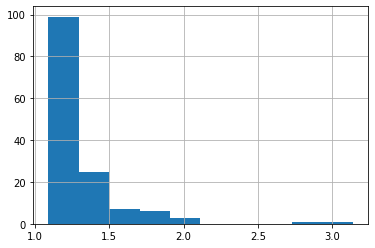

In [74]:
nuclei['compactness'].hist()

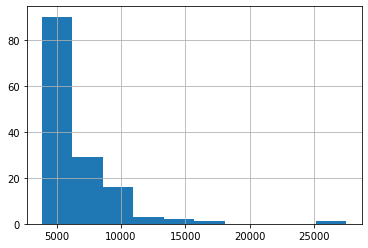

In [75]:
nuclei['area'].hist()

In [148]:
np.sqrt(1-(70/120)**2)

0.8122328620674136

In [141]:
85/np.sqrt(1-0.7**2)

119.02380714238083

In [119]:
fig = plot_multiple_scatter(
    nuclei[nuclei['image_number']==20].copy(),
    x='major_axis_length',
    y='minor_axis_length',
    c='exclude'
)

fig

In [121]:
fig = plot_multiple_scatter(
    nuclei[nuclei['image_number']==20].copy(),
    x='area',
    y='eccentricity',
    c='exclude'
)

fig

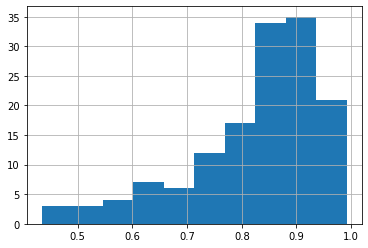

In [109]:
(nuclei['minor_axis_length']/nuclei['major_axis_length']).hist()

# Plot with Bokeh

In [12]:
save = False

In [13]:
for image_number in [
    3, 8, 18, 
    20
]:
    
    # subset by image
    nuclei_subset = nuclei[nuclei['image_number']==image_number].copy()
    puncta_subset = pd.merge(
        left=nuclei_subset[["image_number", 'object_number']],
        right=puncta.loc[:, puncta.columns != 'object_number'],
        left_on=["image_number", 'object_number'],
        right_on=['image_number', 'reassigned_object_number'],
        how="left",
    ).dropna(subset=['reassigned_object_number'])  # left join without duplicates

    
    # add nuclei
    nuclei_subset['angle'] = nuclei_subset['orientation'].apply(lambda x: x/360*3.14159)
    nuclei_source = ColumnDataSource(nuclei_subset.loc[
        # (nuclei_subset['object_number']==2)
        :, ["object_number", "center_x", "center_y", "major_axis_length", "minor_axis_length", "angle"]
    ].rename(
        columns={
            "center_x": "x",
            "center_y": "y",
            "major_axis_length": "h",
            "minor_axis_length": "w"
        }
    ).to_dict("list"))
    nuclei_glyph = Ellipse(x="x", y="y", width="w", height="h", angle='angle', line_color='#FFFFFF', fill_color='#000fff', line_width=1.2)
    text_glyph = Text(x="x", y="y", text="object_number", text_color="white", text_font_size = {'value': '13px'})
    

    # add puncta
    puncta_subset['angle'] = puncta_subset['orientation'].apply(lambda x: x/360*3.14159)
    
    puncta_source = ColumnDataSource(puncta_subset[
        ["center_x", "center_y", "major_axis_length", "minor_axis_length", "angle"]
    ].rename(
        columns={
            "center_x": "x",
            "center_y": "y",
            "major_axis_length": "h",
            "minor_axis_length": "w"
        }
    ).to_dict("list"))
    puncta_glyph = Ellipse(x="x", y="y", width="w", height="h", angle='angle', fill_color='#ff2b00', line_alpha=0, )
    
    puncta_text_df = puncta_subset.groupby(['image_number', 'object_number'])[['center_x', 'center_y']].mean().reset_index()
    puncta_text_source = ColumnDataSource(puncta_centers.loc[
        (puncta_centers['image_number']==image_number)
        , ["image_number", "reassigned_object_number", "center_x", "center_y",]
    ].rename(
        columns={
            "center_x": "x",
            "center_y": "y"
        }
    ).to_dict("list"))
    puncta_text_glyph = Text(x="x", y="y", text="reassigned_object_number", text_color="orange", text_font_size = {'value': '13px'})
    
    
    # add puncta
    plot = Plot(
        title=Title(text=f"Puncta {image_number}"),
        width=1000, height=800,
        match_aspect=True,
        toolbar_location=None
    )
    plot.add_glyph(nuclei_source, nuclei_glyph)
    plot.add_glyph(nuclei_source, text_glyph)
    plot.add_glyph(puncta_source, puncta_glyph)
    plot.add_glyph(puncta_text_source, puncta_text_glyph)

    xaxis = LinearAxis()
    plot.add_layout(xaxis, 'above')
    plot.x_range.start = 0
    plot.x_range.end = 1280

    yaxis = LinearAxis()
    plot.add_layout(yaxis, 'left')
    plot.y_range.start = 1024
    plot.y_range.end = 0

    plot.add_layout(Grid(dimension=0, ticker=xaxis.ticker))
    plot.add_layout(Grid(dimension=1, ticker=yaxis.ticker))

    show(plot)

    # save
    if save:
        export_png(plot, filename=f"figures/puncta_{image_number}.png")

In [36]:
nuclei[
    (nuclei['image_number']==20)
    & (nuclei['object_number']==46)
]

,image_number,object_number,path_name_tif,file_name_tif,center_x,center_y,bounding_box_min_x,bounding_box_max_x,bounding_box_min_y,bounding_box_max_y,bounding_box_area,orientation,major_axis_length,minor_axis_length,area,convex_area,perimeter,eccentricity,form_factor,compactness
134,20,46,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,338.84882,825.753065,254,427,756,890,23182,72.311387,172.448813,112.898912,14109,15800,529.51176,0.755906,0.632346,1.581412


In [37]:
puncta

,image_number,object_number,parent_manual_nuclei,center_x,center_y,bounding_box_min_x,bounding_box_max_x,bounding_box_min_y,bounding_box_max_y,bounding_box_area,orientation,major_axis_length,minor_axis_length,area,convex_area,perimeter,eccentricity,form_factor,compactness,integrated_intensity,min_intensity,max_intensity,mean_intensity,median_intensity,edge_integrated_intensity,edge_min_intensity,edge_max_intensity,edge_mean_intensity
0,3,1,2,275.000000,131.000000,275,276,131,132,1,45.000000,0.000000,0.000000,1,1,0.000000,0.000000,inf,0.000000,0.023011,0.023011,0.023011,0.023011,0.023011,0.023011,0.023011,0.023011,0.023011
1,3,2,2,280.000000,131.000000,280,281,131,132,1,45.000000,0.000000,0.000000,1,1,0.000000,0.000000,inf,0.000000,0.022431,0.022431,0.022431,0.022431,0.022431,0.022431,0.022431,0.022431,0.022431
2,3,3,2,285.500000,133.000000,285,287,133,134,2,90.000000,2.000000,0.000000,2,2,0.000000,1.000000,inf,0.000000,0.045701,0.022522,0.023178,0.022850,0.023178,0.045701,0.022522,0.023178,0.022850
3,3,4,2,280.142857,134.785714,278,283,133,138,25,-43.349067,5.195207,3.772838,14,16,12.485281,0.687467,1.128603,0.886051,0.321813,0.022461,0.024674,0.022987,0.022843,0.227497,0.022461,0.023072,0.022750
4,3,5,2,277.000000,136.000000,277,278,136,137,1,45.000000,0.000000,0.000000,1,1,0.000000,0.000000,inf,0.000000,0.022675,0.022675,0.022675,0.022675,0.022675,0.022675,0.022675,0.022675,0.022675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,20,851,39,149.800000,923.200000,149,152,922,925,9,45.000000,3.836665,1.788854,5,7,4.000000,0.884652,3.926991,0.254648,0.114504,0.021988,0.023651,0.022901,0.023102,0.114504,0.021988,0.023651,0.022901
2126,20,852,39,142.500000,924.500000,142,144,924,926,4,45.000000,2.000000,2.000000,4,4,4.000000,0.000000,3.141593,0.318310,0.094194,0.022538,0.024933,0.023548,0.024094,0.094194,0.022538,0.024933,0.023548
2127,20,853,42,336.000000,926.500000,336,337,926,928,2,0.000000,2.000000,0.000000,2,2,0.000000,1.000000,inf,0.000000,0.046433,0.023041,0.023392,0.023217,0.023392,0.046433,0.023041,0.023392,0.023217
2128,20,854,39,142.000000,932.000000,142,143,932,933,1,45.000000,0.000000,0.000000,1,1,0.000000,0.000000,inf,0.000000,0.022248,0.022248,0.022248,0.022248,0.022248,0.022248,0.022248,0.022248,0.022248


In [33]:
puncta_centers[
    (puncta_centers['image_number']==20)
    & (puncta_centers['parent_manual_nuclei']==35)
]

,image_number,parent_manual_nuclei,center_x,center_y
106,20,35.0,315.818346,793.15068


In [171]:
puncta_subset['object_number'].value_counts()

27    24
Name: object_number, dtype: int64

In [130]:
nuclei.loc[
    (nuclei['image_number']==18) &
    (nuclei['major_axis_length'] > 120)
    & (nuclei['exclude']=='false')]

,image_number,object_number,path_name_tif,file_name_tif,center_x,center_y,bounding_box_min_x,bounding_box_max_x,bounding_box_min_y,bounding_box_max_y,bounding_box_area,orientation,major_axis_length,minor_axis_length,area,convex_area,perimeter,eccentricity,form_factor,compactness,image_number_str,color,exclude
60,18,1,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP91_48_B6_CRE_006.tif,233.139847,128.538564,172,291,76,180,12376,60.930330,122.456234,87.027807,8259,8557,359.788889,0.703510,0.801755,1.247263,18,#2ca02c,false
80,18,21,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP91_48_B6_CRE_006.tif,1065.684826,598.754465,1024,1106,525,666,11562,-12.466548,147.083081,71.019647,7783,8419,384.918831,0.875701,0.660113,1.514891,18,#2ca02c,false
82,18,23,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP91_48_B6_CRE_006.tif,584.670684,657.497809,532,631,598,729,12969,23.635901,136.571021,87.357480,9128,9575,386.575685,0.768667,0.767567,1.302817,18,#2ca02c,false
86,18,27,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP91_48_B6_CRE_006.tif,599.335583,777.516929,538,657,714,836,14518,45.234123,141.630896,83.162464,9038,9621,393.060967,0.809458,0.735127,1.360309,18,#2ca02c,false
87,18,28,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP91_48_B6_CRE_006.tif,187.216799,838.890001,135,239,783,894,11544,41.278243,128.883559,73.158518,7191,7485,349.747258,0.823282,0.738738,1.353660,18,#2ca02c,false


# Manually exclude

In [115]:
nuclei['exclude'] = 'false'

In [ ]:
nuclei.loc[
    (nuclei['image_number']==18) & (nuclei['object_number'].isin(
        []
    )),
    'exclude'
] = 'true'

In [116]:
nuclei.loc[
    (nuclei['image_number']==20) & (nuclei['object_number'].isin(
        [1, 6, 9, 19, 29, 24, 25, 29, 20, 33, 32, 36, 46]
    )),
    'exclude'
] = 'true'

In [113]:
nuclei

,image_number,object_number,path_name_tif,file_name_tif,center_x,center_y,bounding_box_min_x,bounding_box_max_x,bounding_box_min_y,bounding_box_max_y,bounding_box_area,orientation,major_axis_length,minor_axis_length,area,convex_area,perimeter,eccentricity,form_factor,compactness,image_number_str,color,exclude
0,3,1,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP67_18_B6_CRE_003.tif,693.094713,59.080090,655,733,19,98,6162,-45.901057,83.647997,67.946172,4445,4584,257.764502,0.583258,0.840689,1.189500,3,#1f77b4,0
1,3,2,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP67_18_B6_CRE_003.tif,295.184921,118.996760,255,334,81,161,6320,62.309321,82.042679,72.995776,4629,4861,269.078211,0.456489,0.803415,1.244687,3,#1f77b4,0
2,3,3,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP67_18_B6_CRE_003.tif,282.528024,182.998269,246,326,139,230,7280,28.746600,87.722871,71.947327,4621,5266,300.569588,0.572125,0.642770,1.555766,3,#1f77b4,0
3,3,4,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP67_18_B6_CRE_003.tif,211.894644,190.457987,151,268,117,271,18018,27.182444,161.416808,89.135110,10830,11781,442.700577,0.833709,0.694413,1.440064,3,#1f77b4,0
4,3,5,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP67_18_B6_CRE_003.tif,345.912244,212.319708,297,393,171,253,7872,-56.899251,92.188865,74.995123,5333,5644,291.119841,0.581573,0.790748,1.264626,3,#1f77b4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,20,49,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,670.420682,889.673483,620,720,840,940,10000,-44.008837,106.017171,92.613121,7678,7975,346.190909,0.486704,0.805057,1.242148,20,#d62728,0
138,20,50,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,152.038609,896.950833,98,215,842,959,13689,-33.369636,124.780571,100.095939,9661,10074,392.717821,0.597088,0.787174,1.270367,20,#d62728,0
139,20,51,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,1024.776855,894.395070,974,1081,841,947,11342,50.501634,103.484026,97.169572,7829,8290,358.433550,0.343968,0.765771,1.305874,20,#d62728,0
140,20,52,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,249.682106,912.143527,195,305,855,969,12540,-36.079119,118.214951,93.459472,8528,9052,382.351334,0.612347,0.733047,1.364169,20,#d62728,0


In [103]:
nuclei.loc[
    (nuclei['image_number']==20)
].sort_values('eccentricity', ascending=False)

,image_number,object_number,path_name_tif,file_name_tif,center_x,center_y,bounding_box_min_x,bounding_box_max_x,bounding_box_min_y,bounding_box_max_y,bounding_box_area,orientation,major_axis_length,minor_axis_length,area,convex_area,perimeter,eccentricity,form_factor,compactness,image_number_str,color
97,20,9,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,142.915938,177.298469,74,231,140,218,12246,-88.923614,163.534439,71.186995,8232,9608,447.546248,0.900284,0.516463,1.936246,20,#d62728
113,20,25,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,1092.620376,468.881140,1065,1125,414,527,6780,2.294079,119.530229,55.012879,4947,5629,356.090404,0.887793,0.490265,2.039712,20,#d62728
124,20,36,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,214.644975,726.248367,140,287,648,810,23814,-42.506239,181.883149,95.730496,13323,14306,544.281313,0.850281,0.565152,1.769436,20,#d62728
107,20,19,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,450.296092,375.606502,387,522,315,442,17145,56.597577,150.568346,83.066397,8521,10574,554.126984,0.834052,0.348724,2.867597,20,#d62728
117,20,29,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,418.864360,556.653892,361,485,477,626,18476,18.813228,162.462950,98.532424,10985,12923,500.925974,0.795090,0.550127,1.817763,20,#d62728
89,20,1,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,451.532269,43.446510,389,505,3,86,9628,-72.949068,114.125015,69.715940,5702,6659,366.019336,0.791728,0.534846,1.869696,20,#d62728
133,20,45,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,238.008560,807.729228,194,280,762,869,9202,-32.262686,102.831322,62.862468,4790,5679,326.510714,0.791386,0.564613,1.771126,20,#d62728
134,20,46,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,338.848820,825.753065,254,427,756,890,23182,72.311387,172.448813,112.898912,14109,15800,529.511760,0.755906,0.632346,1.581412,20,#d62728
94,20,6,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,849.756284,88.946136,799,891,39,153,10488,12.531849,120.778891,82.667505,6405,8736,502.457936,0.729057,0.318808,3.136681,20,#d62728
112,20,24,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,1003.554279,478.505868,960,1044,440,515,6300,-70.935350,88.830422,61.557800,4090,4614,305.078211,0.720956,0.552218,1.810878,20,#d62728


In [101]:
nuclei.loc[
    (nuclei["image_number"] == 20) & (nuclei["object_number"] == 21),
    ["eccentricity"]
]

,eccentricity
109,0.645191


In [94]:
nuclei_subset

,image_number,object_number,path_name_tif,file_name_tif,center_x,center_y,bounding_box_min_x,bounding_box_max_x,bounding_box_min_y,bounding_box_max_y,bounding_box_area,orientation,major_axis_length,minor_axis_length,area,convex_area,perimeter,eccentricity,form_factor,compactness,image_number_str,color,angle
89,20,1,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,451.532269,43.446510,389,505,3,86,9628,-72.949068,114.125015,69.715940,5702,6659,366.019336,0.791728,0.534846,1.869696,20,#d62728,-0.636600
90,20,2,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,768.059143,76.998192,730,806,44,111,5092,-72.981958,76.380695,65.820941,3872,4234,287.450794,0.507336,0.588868,1.698173,20,#d62728,-0.636887
91,20,3,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,252.768956,114.289370,209,298,75,158,7387,-54.801769,98.222061,69.737246,5315,5590,295.220346,0.704206,0.766338,1.304907,20,#d62728,-0.478235
92,20,4,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,167.591796,108.171559,123,212,69,147,6942,85.056518,89.655219,78.066698,5485,5607,278.693434,0.491738,0.887428,1.126852,20,#d62728,0.742258
93,20,5,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,439.561436,115.904779,392,480,74,157,7304,43.355009,88.949131,78.927668,5461,5668,291.764502,0.461126,0.806152,1.240460,20,#d62728,0.378344
94,20,6,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,849.756284,88.946136,799,891,39,153,10488,12.531849,120.778891,82.667505,6405,8736,502.457936,0.729057,0.318808,3.136681,20,#d62728,0.109361
95,20,7,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,679.120776,123.240680,644,723,80,169,7031,27.605611,87.702779,67.733095,4587,4821,274.605122,0.635255,0.764401,1.308214,20,#d62728,0.240904
96,20,8,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,732.556236,170.698113,694,772,133,210,6006,-56.437536,72.738127,71.903930,4081,4207,244.492424,0.151015,0.857918,1.165613,20,#d62728,-0.492510
97,20,9,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,142.915938,177.298469,74,231,140,218,12246,-88.923614,163.534439,71.186995,8232,9608,447.546248,0.900284,0.516463,1.936246,20,#d62728,-0.776004
98,20,10,/Users/sarahpyfrom/Dropbox/Mac/Desktop/Sarah_S...,sSP95_48_SAT_CRE_004.tif,654.677340,198.532225,607,696,162,238,6764,61.114936,90.186557,70.072867,4872,5056,278.320851,0.629529,0.790361,1.265244,20,#d62728,0.533328


# EDA